In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/HSBC_case_study.csv")

In [ ]:
df.shape

(50000, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         50000 non-null  object 
 1   INCOME      50000 non-null  float64
 2   TRB         50000 non-null  float64
 3   DIG_ACTIVE  50000 non-null  int64  
 4   FX_TRANS    50000 non-null  int64  
 5   PAYME       50000 non-null  int64  
 6   CC          50000 non-null  int64  
 7   LN          50000 non-null  int64  
 8   MT          50000 non-null  int64  
 9   TD          50000 non-null  int64  
 10  SC          50000 non-null  int64  
 11  SP          50000 non-null  int64  
 12  BD          50000 non-null  int64  
 13  MPF         50000 non-null  int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 5.3+ MB


In [ ]:
df.describe()

,INCOME,TRB,DIG_ACTIVE,FX_TRANS,PAYME,CC,LN,MT,TD,SC,SP,BD,MPF
count,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,3.123016e+04,1.627904e+05,0.818160,0.237360,0.66570,0.48838,0.076440,0.077520,0.093200,0.096360,0.049880,0.071360,0.28964
std,2.589240e+04,3.917090e+05,0.385716,0.425469,0.47175,0.49987,0.265703,0.267417,0.290715,0.295087,0.217699,0.257428,0.45360
min,-1.966988e+04,0.000000e+00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.855612e+04,4.681005e+03,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2.710789e+04,3.790827e+04,1.000000,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,3.986781e+04,1.703579e+05,1.000000,0.000000,1.00000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,1.380715e+06,2.282008e+07,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [ ]:
# coverting age bands into numeric values for clustering
age_map = {'18-24': 0, '25-29': 1, '30-34': 2}
df['AGE_NUM'] = df['AGE'].map(age_map)

feature_columns = ['DIG_ACTIVE', 'FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']

# Creating a new feature: TRB_TO_INCOME Ratio
# This ratio helps the model understand how customers accumulate wealth relative to income,
# which is a critical aspect of their financial behavior.
# Customers with a high TRB-to-income ratio might be more interested in wealth
# management products, while customers with a low ratio may have more basic
# banking needs.
df['TRB_TO_INCOME'] = df['TRB'] / (df['INCOME'])


# Creating a new feature: Product_Count
# This feature tells us how engaged a customer is with the bank’s services.
# Clustering customers based on their engagement (number of services they use)
# helps segment customers into groups with similar needs, allowing HSBC to
# identify (1) loyal customers who use many products and services and (2)
# customers using fewer products.
df['Product_Count'] = df[feature_columns].sum(axis=1)

combined_feature_column = ['AGE_NUM', 'INCOME', 'TRB', 'TRB_TO_INCOME', 'Product_Count'] + feature_columns

print(df[['TRB_TO_INCOME', 'Product_Count']].head())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[combined_feature_column])

X_scaled.shape

   TRB_TO_INCOME  Product_Count
0       6.885328              2
1       0.000092              2
2       6.377908              1
3       0.003073              2
4       0.070000              2


(50000, 16)

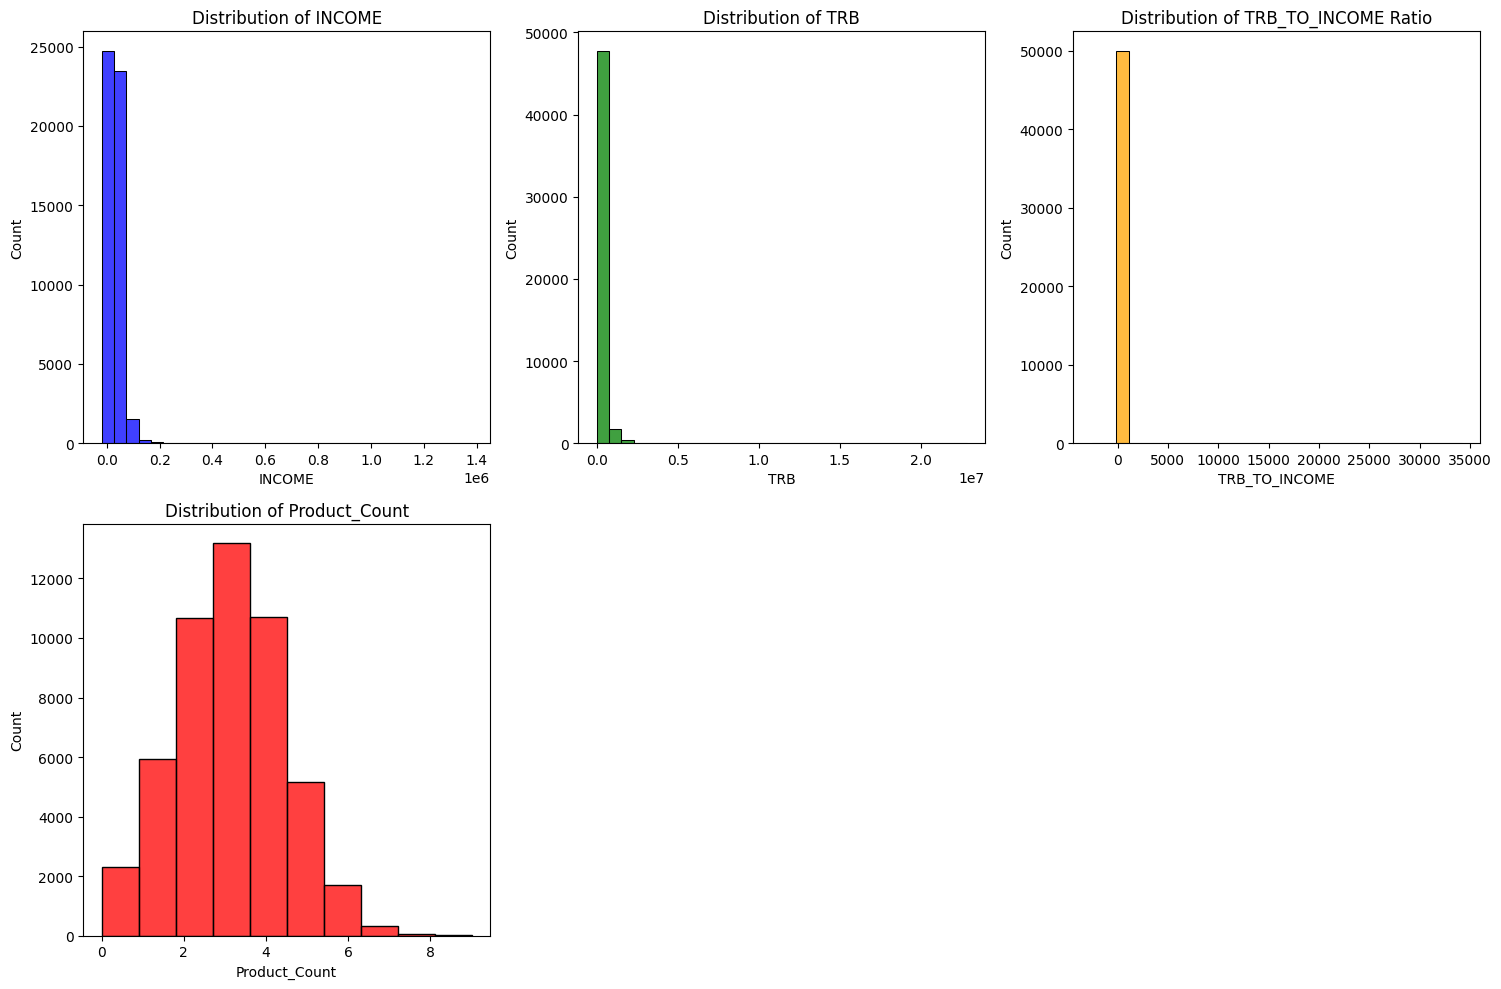

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(df['INCOME'], kde=False, bins=30, color='blue')
plt.title("Distribution of INCOME")

plt.subplot(2, 3, 2)
sns.histplot(df['TRB'], kde=False, bins=30, color='green')
plt.title("Distribution of TRB")

plt.subplot(2, 3, 3)
sns.histplot(df['TRB_TO_INCOME'], kde=False, bins=30, color='orange')
plt.title("Distribution of TRB_TO_INCOME Ratio")

plt.subplot(2, 3, 4)
sns.histplot(df['Product_Count'], kde=False, bins=10, color='red')
plt.title("Distribution of Product_Count")

plt.tight_layout()
plt.show()

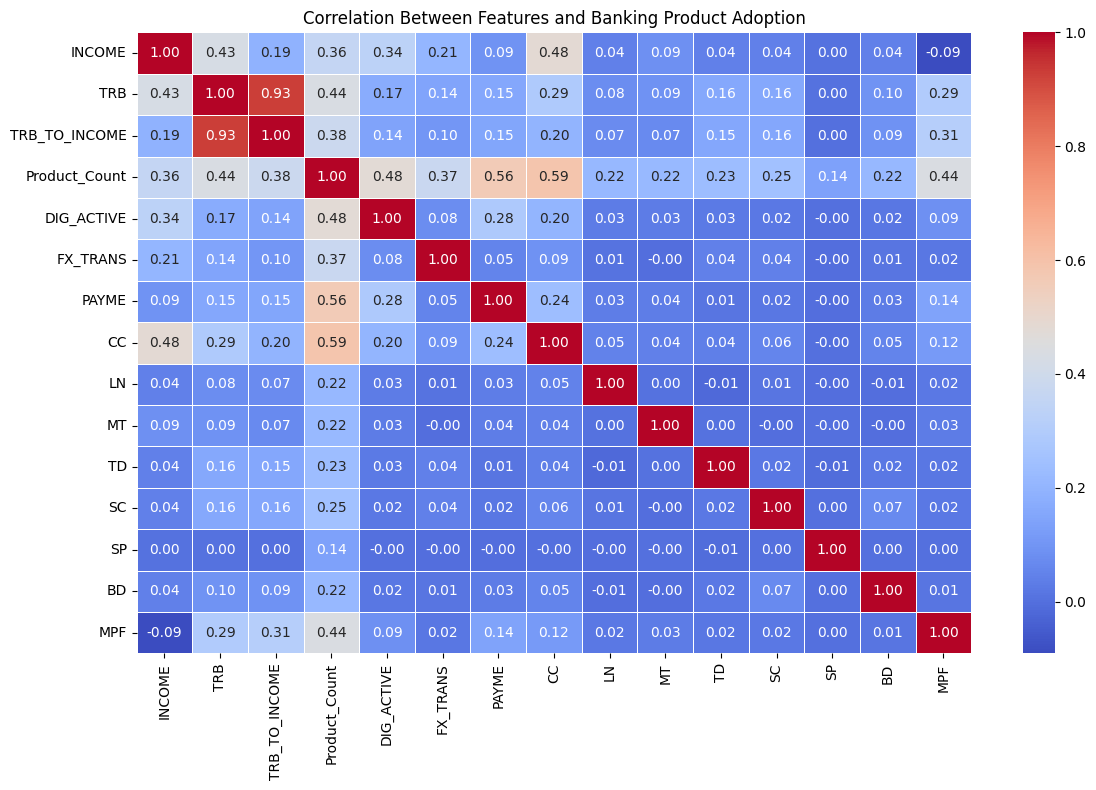

In [ ]:
feature_columns = ['DIG_ACTIVE', 'FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']

corr_matrix = df[['INCOME', 'TRB', 'TRB_TO_INCOME', 'Product_Count'] + feature_columns].corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Features and Banking Product Adoption")
plt.tight_layout()
plt.show()

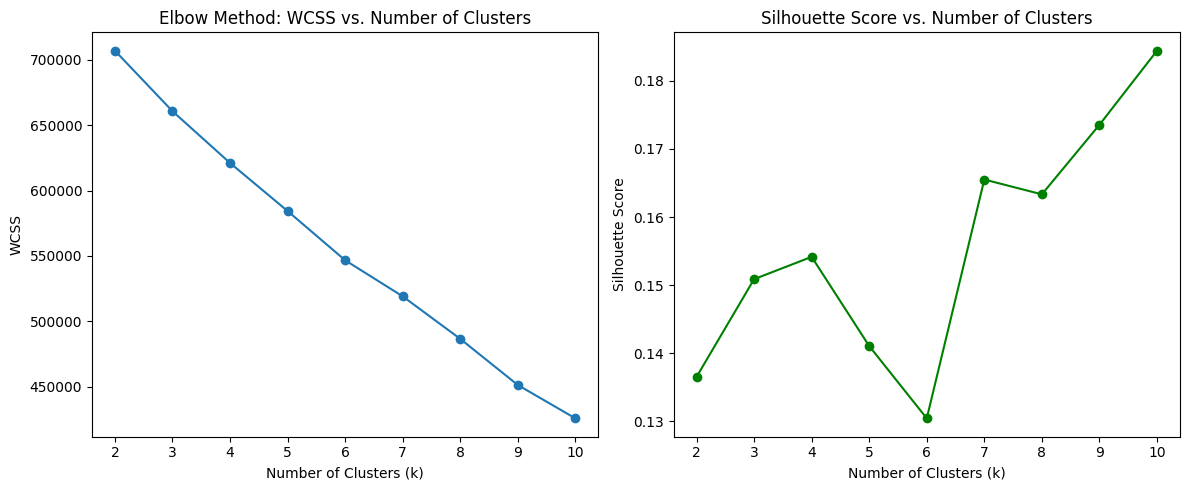

In [ ]:
wcss = []
sil_scores = []

K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(K_range), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method: WCSS vs. Number of Clusters")

plt.subplot(1, 2, 2)
plt.plot(list(K_range), sil_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")

plt.tight_layout()
plt.show()

In [ ]:
k_means=KMeans(n_clusters=4)

In [ ]:
k_means.fit(X_scaled)

KMeans(n_clusters=4)

In [ ]:
k_means.labels_

array([0, 2, 2, ..., 1, 3, 3], dtype=int32)

In [ ]:
df["Which_Cluster"]
df.head()

,AGE,INCOME,TRB,DIG_ACTIVE,FX_TRANS,PAYME,CC,LN,MT,TD,SC,SP,BD,MPF,AGE_NUM,TRB_TO_INCOME,Product_Count,Which_Cluster
0,30-34,9012.13,62051.47,0,0,1,0,0,0,0,0,0,0,1,2,6.885328,2,1
1,30-34,44108.03,4.05,1,0,0,1,0,0,0,0,0,0,0,2,0.000092,2,1
2,25-29,45782.41,291996.00,1,0,0,0,0,0,0,0,0,0,0,1,6.377908,1,1
3,30-34,26525.41,81.50,1,0,0,0,0,0,0,1,0,0,0,2,0.003073,2,0
4,30-34,20671.51,1447.01,1,0,1,0,0,0,0,0,0,0,0,2,0.070000,2,1


In [ ]:
df.Which_Cluster.value_counts().sort_index()

,count
Which_Cluster,
0,4288
1,18477
2,23361
3,3874


In [ ]:
clust_profile=df.drop(['AGE'],axis=1)
clust_profile=clust_profile.groupby('Which_Cluster').mean()
clust_profile['freq']=df.Which_Cluster.value_counts().sort_index()
clust_profile

,INCOME,TRB,DIG_ACTIVE,FX_TRANS,PAYME,CC,LN,MT,TD,SC,SP,BD,MPF,AGE_NUM,TRB_TO_INCOME,Product_Count,freq
Which_Cluster,,,,,,,,,,,,,,,,,
0,39367.335942,370619.731576,0.878498,0.305271,0.715252,0.595382,0.090019,0.000466,0.121502,0.992537,0.054338,0.135728,0.329058,1.201026,9.764544,4.218050,4288
1,22694.422067,65175.592232,0.613574,0.103642,0.357038,0.145641,0.032365,0.000000,0.044921,0.010878,0.031877,0.031661,0.102127,1.004709,3.495212,1.473724,18477
2,35276.235329,186243.566099,0.962502,0.331878,0.890801,0.727880,0.108129,0.000000,0.125594,0.000000,0.063353,0.091520,0.422713,1.104833,9.582325,3.724370,23361
3,38535.876693,256897.023351,0.856737,0.229995,0.725607,0.560403,0.080537,1.000000,0.096799,0.093185,0.049561,0.067888,0.337894,1.250129,7.011673,4.098606,3874


- Cluster 0 represents wealthy customers aged between 25-29 years, with significant financial holdings and high engagement in digital banking. These customers are tech-savvy, digitally engaged, and have multiple products with HSBC.

- Cluster 1 represents younger customers, aged around 18-24 years old, with low income and modest savings. These customers are less digitally active and engage with fewer products from HSBC, indicating they might be starting their financial journey.

- Cluster 2 represents moderate-income customers aged around 25-29 years, who are highly digitally engaged. These customers have solid savings and use a good number of HSBC’s digital products. They are also tech-savvy and financially stable.

- Cluster 3 represents older, wealthy customers aged 30-34 years, with a healthy balance between income and savings. They are digitally engaged but not as much as Cluster 2, and they use a higher number of products, making them a loyal and valuable customer base for HSBC.

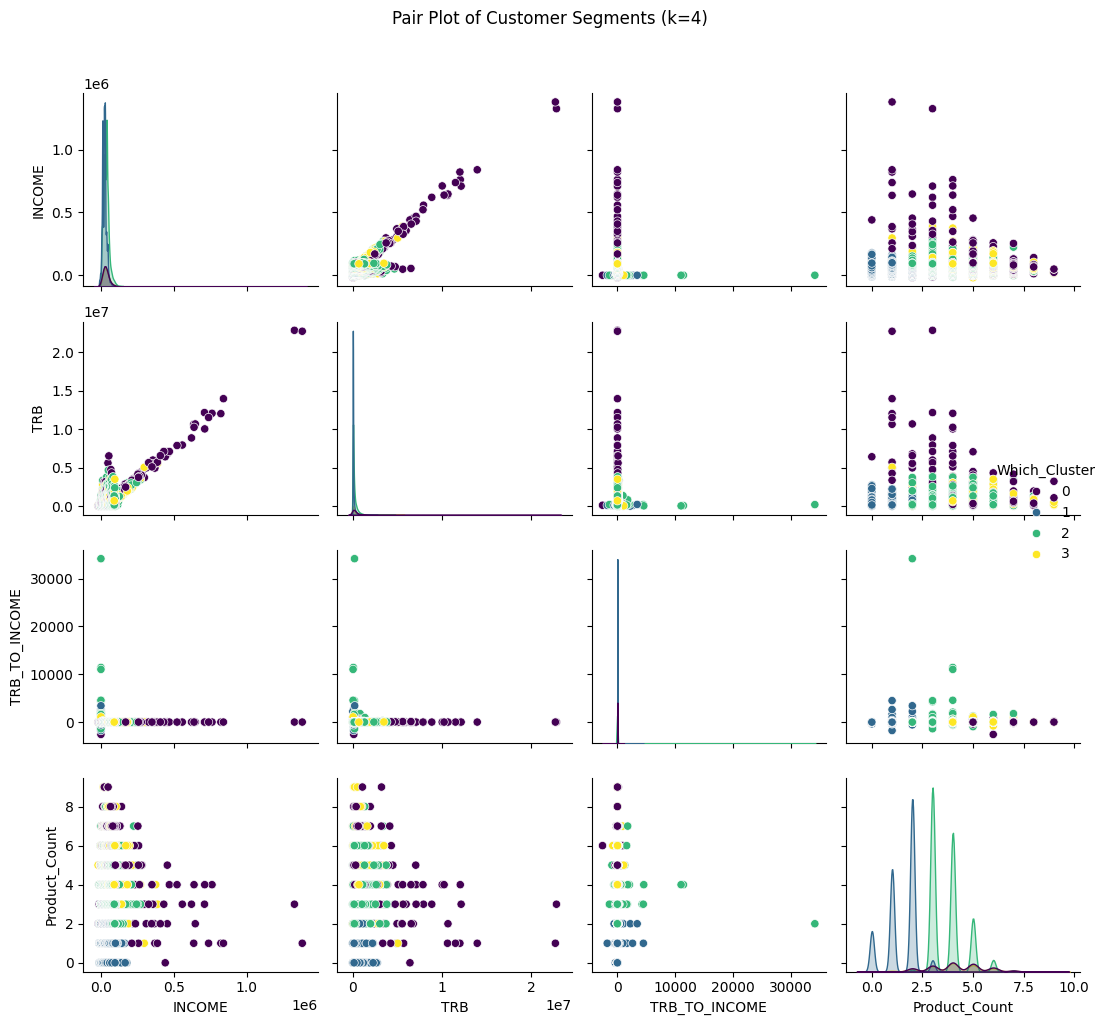

In [ ]:
pairplot_features = ['INCOME', 'TRB', 'TRB_TO_INCOME','Product_Count']

df_pairplot = df[pairplot_features + ['Which_Cluster']]

sns.pairplot(df_pairplot, hue='Which_Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Segments (k=4)', y=1.02)
plt.tight_layout()
plt.show()

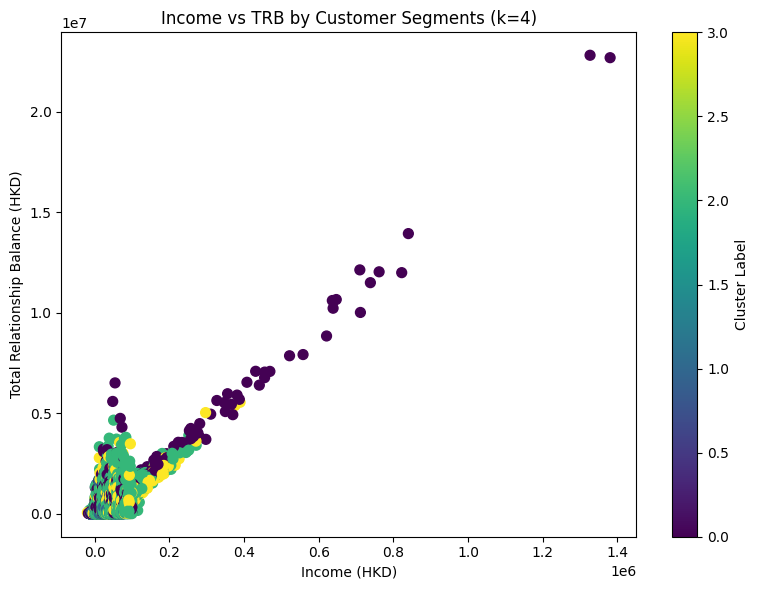

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['INCOME'], df['TRB'], c=df['Which_Cluster'], cmap='viridis', s=50)
plt.xlabel("Income (HKD)")
plt.ylabel("Total Relationship Balance (HKD)")
plt.title("Income vs TRB by Customer Segments (k=4)")
plt.colorbar(label="Cluster Label")
plt.tight_layout()
plt.show()

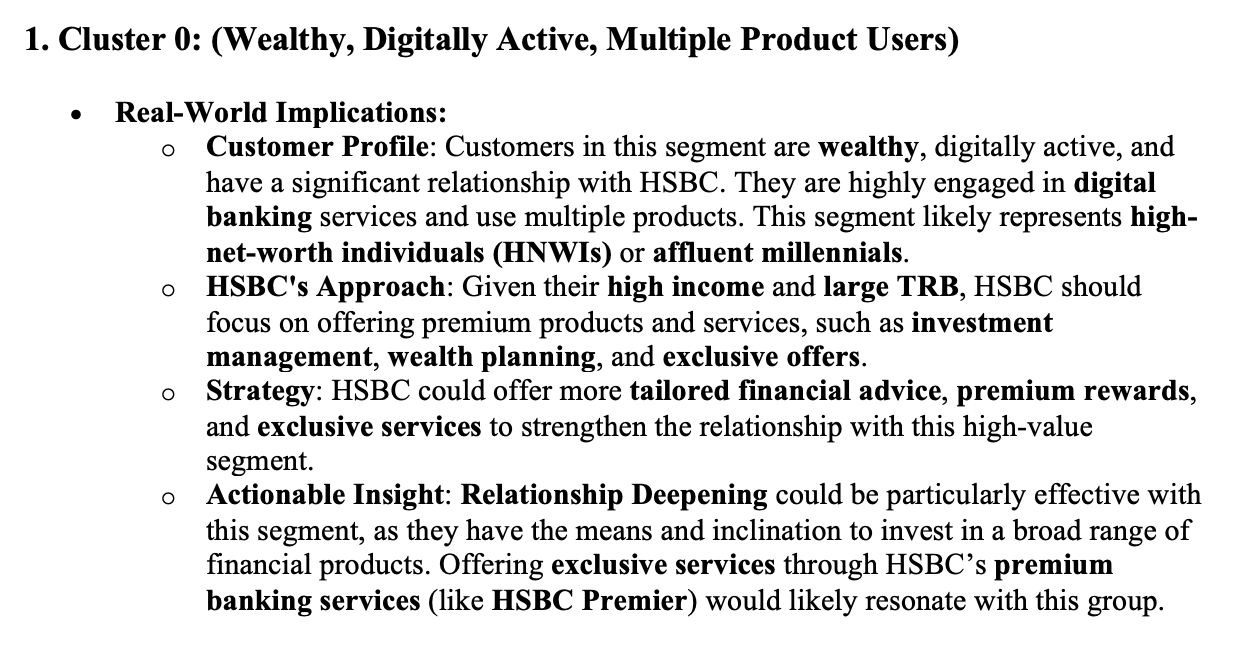

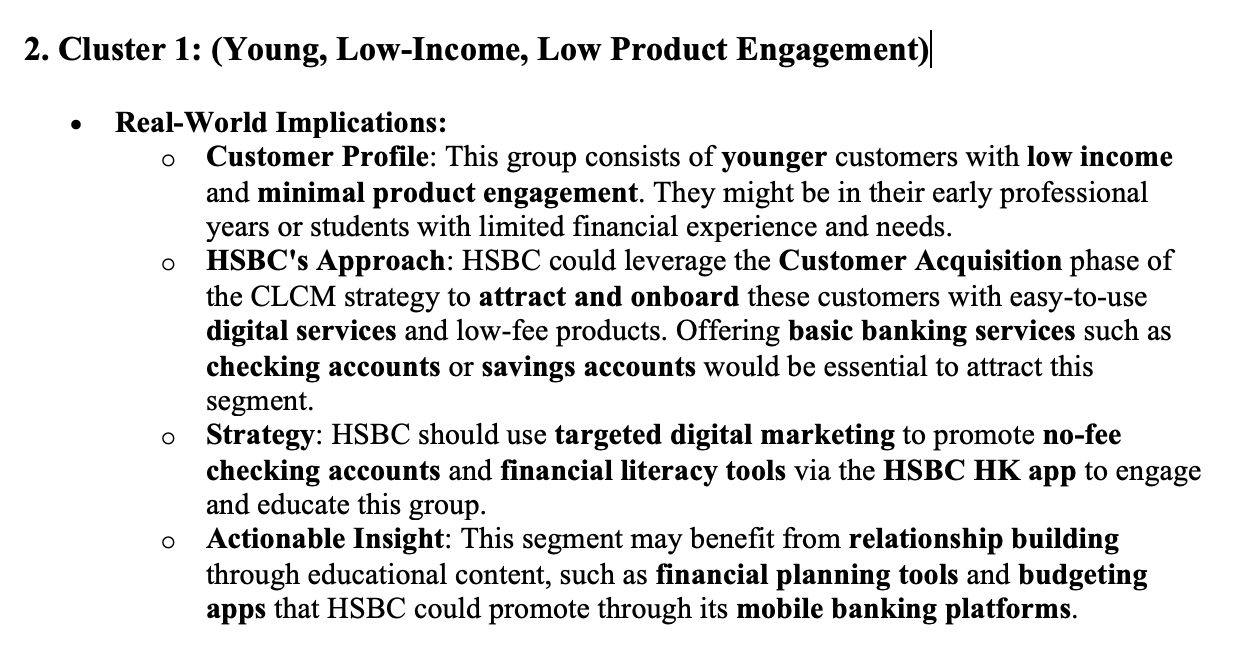

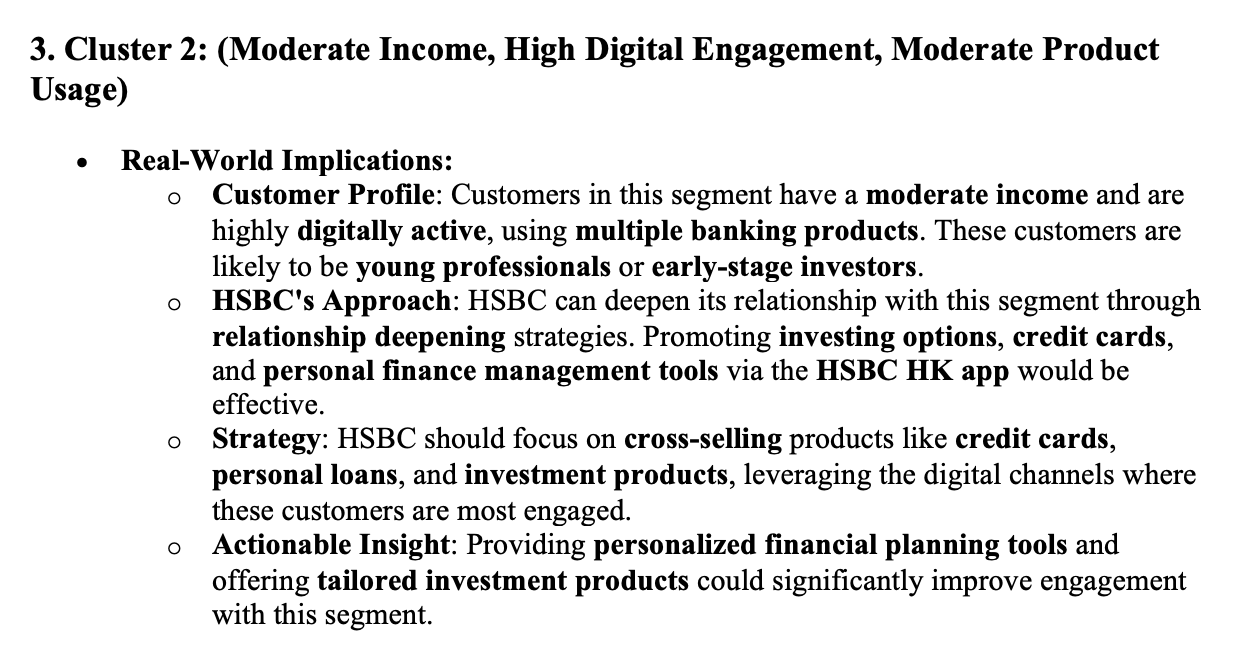

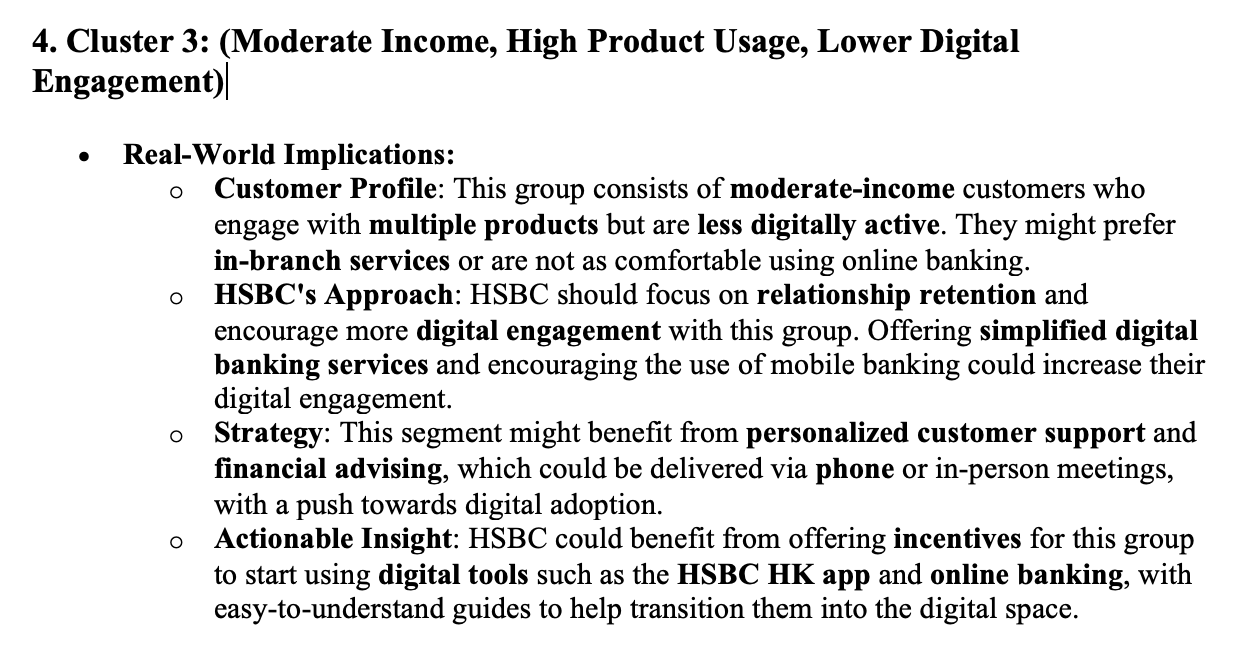

In [ ]:
def cluster_metrics(k_value, X_scaled):

    km = KMeans(n_clusters=k_value, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)

    wcss = km.inertia_
    silhouette = silhouette_score(X_scaled, labels)


    return {
        "WCSS": wcss,
        "Silhouette": silhouette,
    }


In [ ]:
n = X_scaled.shape[1]

k_values = [n, 20, 3]

results = {}

for k_value in k_values:
    print(f"\nEvaluating k = {k_value}")
    results[k_value] = cluster_metrics(k_value, X_scaled)

print("\nComparison of results:")
for k_value, metrics in results.items():
    print(f"k = {k_value}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")


Evaluating k = 16

Evaluating k = 20

Evaluating k = 3

Comparison of results:
k = 16
WCSS: 318573.82329022576
Silhouette: 0.19960122575298825


k = 20
WCSS: 297104.9088017361
Silhouette: 0.23619330874630923


k = 3
WCSS: 660724.1531016545
Silhouette: 0.15088111075721503


